In [2]:
! pip install matplotlib

  Using cached https://files.pythonhosted.org/packages/da/83/d989ee20c78117c737ab40e0318ea221f1aed4e3f5a40b4f93541b369b93/matplotlib-3.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl


In [4]:
# https://simplyml.com/benchmarking-the-singular-value-decomposition/
# https://github.com/charanpald/tyre-hug/blob/master/tyrehug/exp/svdbenchmark.py

import time
import numpy

import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np

from scipy.sparse.linalg import svds
# from sparsesvd import sparsesvd
from sklearn.utils.extmath import randomized_svd
from gensim.models.lsimodel import stochastic_svd

np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/home/filter/anaconda3/envs/hy3/lib']
    define_macros = [('HAVE_CBLAS', None)]
    include_dirs = ['/home/filter/anaconda3/envs/hy3/include']
    language = c
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/home/filter/anaconda3/envs/hy3/lib']
    define_macros = [('HAVE_CBLAS', None)]
    include_dirs = ['/home/filter/anaconda3/envs/hy3/include']
    language = c
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/home/filter/anaconda3/envs/hy3/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/home/filter/anaconda3/envs/h

In [5]:
def time_reps(func, params, reps):
    start = time.time()
    for s in range(reps):
        func(*params)
    print("Executed " + str(func))
    return (time.time() - start) / reps


"""
Compare and contrast different methods of computing the SVD
"""

k = 50
p = 0
reps = 5
density = 10**-3
n_iter = 5
var_range = numpy.arange(1, 11)


def gensim_svd(A, k):
    return stochastic_svd(A, k, A.shape[0], power_iters=n_iter, extra_dims=10)


def time_densities():
    n = 10**4
    densities = var_range * 2 * 10**-3
    times = numpy.zeros((4, densities.shape[0]))

    for i, density in enumerate(densities):
        # Generate random sparse matrix
        inds = numpy.random.randint(int(n), size=(2, int(n * n * density)))
        data = numpy.random.rand(int(n * n * density))
        A = scipy.sparse.csc_matrix((data, inds), (n, n))
        print(A.shape, A.nnz)
        
        times[3, i] = time_reps(gensim_svd, (A, k), reps)
        times[2, i] = time_reps(randomized_svd, (A, k, 10, n_iter), reps)
        times[0, i] = time_reps(svds, (A, k), reps)
#         times[1, i] = time_reps(sparsesvd, (A, k), reps)
        print(n, density, times[:, i])

    plt.figure(0)
#     plt.plot(densities, times[1, :], 'k-', label="sparsesvd")
    plt.plot(densities, times[0, :], 'b-', label="scipy")
    plt.plot(densities, times[2, :], 'b--', label="sklearn (random)")
    plt.plot(densities, times[3, :], 'k--', label="Gensim SVD (random)")

    plt.legend(loc="upper left")
    plt.xlabel("density")
    plt.ylabel("time (s)")
    plt.savefig("time_densities.png", format="png")


# Next, vary the matrix size
def time_ns():
    density = 10**-3
    ns = var_range * 10**4
    times = numpy.zeros((4, ns.shape[0]))

    for i, n in enumerate(ns):
        # Generate random sparse matrix
        inds = numpy.random.randint(int(n), size=(2, int(n * n * density)))
        data = numpy.random.rand(int(n * n * density))
        A = scipy.sparse.csc_matrix((data, inds), (n, n))
        print(A.shape, A.nnz)
        
        times[3, i] = time_reps(gensim_svd, (A, k), reps)
        times[0, i] = time_reps(svds, (A, k), reps)
#         times[1, i] = time_reps(sparsesvd, (A, k), reps)
        times[2, i] = time_reps(randomized_svd, (A, k, 10, n_iter), reps)
        print(n, density, times[:, i])

    plt.figure(1)
#     plt.plot(ns, times[1, :], 'k-', label="sparsesvd")
    plt.plot(ns, times[0, :], 'b-', label="scipy")
    plt.plot(ns, times[2, :], 'b--', label="sklearn (random)")
    plt.plot(ns, times[3, :], 'k--', label="Gensim SVD (random)")

    plt.legend(loc="upper left")
    plt.xlabel("n")
    plt.ylabel("time (s)")
    plt.savefig("time_ns.png", format="png")


def time_ks():
    n = 10**4
    density = 10**-3
    ks = var_range * 20
    times = numpy.zeros((4, ks.shape[0]))

    for i, k in enumerate(ks):
        # Generate random sparse matrix
        inds = numpy.random.randint(int(n), size=(2, int(n * n * density)))
        data = numpy.random.rand(int(n * n * density))
        A = scipy.sparse.csc_matrix((data, inds), (n, n))
        print(A.shape, A.nnz)
        
        times[3, i] = time_reps(gensim_svd, (A, k), reps)
        times[0, i] = time_reps(svds, (A, k), reps)
#         times[1, i] = time_reps(sparsesvd, (A, k), reps)
        times[2, i] = time_reps(randomized_svd, (A, k, 10, n_iter), reps)
        print(n, density, times[:, i])

    plt.figure(2)
#     plt.plot(ks, times[1, :], 'k-', label="sparsesvd")
    plt.plot(ks, times[0, :], 'b-', label="scipy")
    plt.plot(ks, times[2, :], 'b--', label="sklearn (random)")
    plt.plot(ks, times[3, :], 'k--', label="Gensim SVD (random)")

    plt.legend(loc="upper left")
    plt.xlabel("k")
    plt.ylabel("time (s)")
    plt.savefig("time_ks.png", format="png")

(10000, 10000) 199823
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function randomized_svd at 0x7f4e43efe048>
Executed <function svds at 0x7f4e443db598>
10000 0.002 [0.72477307 0.         0.2160953  0.22866769]
(10000, 10000) 399242
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function randomized_svd at 0x7f4e43efe048>
Executed <function svds at 0x7f4e443db598>
10000 0.004 [1.04061861 0.         0.2940403  0.28254018]
(10000, 10000) 598251
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function randomized_svd at 0x7f4e43efe048>
Executed <function svds at 0x7f4e443db598>
10000 0.006 [1.35831065 0.         0.36506567 0.34413681]
(10000, 10000) 796816
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function randomized_svd at 0x7f4e43efe048>
Executed <function svds at 0x7f4e443db598>
10000 0.008 [1.81681256 0.         0.44465284 0.44522762]
(10000, 10000) 994973
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function randomized

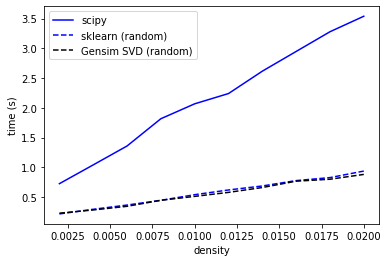

In [6]:
time_densities()

(10000, 10000) 99963
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
10000 0.001 [0.56332397 0.         0.16327772 0.15186725]
(20000, 20000) 399773
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
20000 0.001 [2.48298349 0.         0.60912576 0.61790543]
(30000, 30000) 899527
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
30000 0.001 [5.60239406 0.         1.39338412 1.45393682]
(40000, 40000) 1599206
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
40000 0.001 [11.30199447  0.          2.41360564  2.59306173]
(50000, 50000) 2498782
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds 

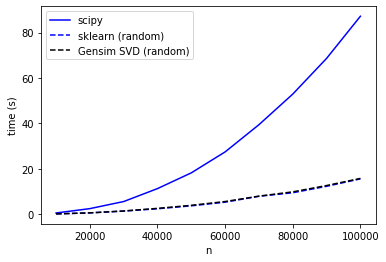

In [7]:
time_ns()

(10000, 10000) 99950
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
10000 0.001 [0.1628334  0.         0.06912408 0.06188965]
(10000, 10000) 99953
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
10000 0.001 [0.37151818 0.         0.12871561 0.11909833]
(10000, 10000) 99951
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
10000 0.001 [0.77775002 0.         0.19969969 0.19150925]
(10000, 10000) 99952
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e443db598>
Executed <function randomized_svd at 0x7f4e43efe048>
10000 0.001 [1.278546   0.         0.29540129 0.30497289]
(10000, 10000) 99951
Executed <function gensim_svd at 0x7f4e4239ff28>
Executed <function svds at 0x7f4e4

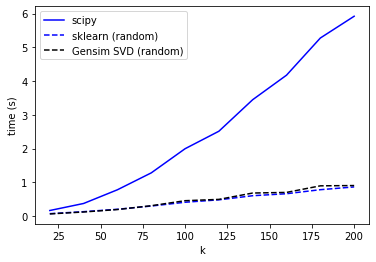

In [8]:
time_ks()

In [ ]:
plt.show()